# TVA

In [141]:
import warnings

warnings.filterwarnings("ignore")

from src import utils
from src.outcomes import plurality_outcome
from src.happiness_level import HappinessLevel
from src.strategic_voting_risk import StrategicVoting
import os
import numpy as np

In [2]:
path_voting = "input/voting_result.json"
if "env" in os.environ:
    if os.environ["env"] == "docker":
        path_voting = "/input/voting_result.json"

This is the voting input

In [60]:
voting = utils.read_voting(path_voting, table_name="voting5")
voting_table = voting.to_pandas()
voting_table


Winner: C
{'A': 1, 'B': 2, 'C': 3, 'D': 0}

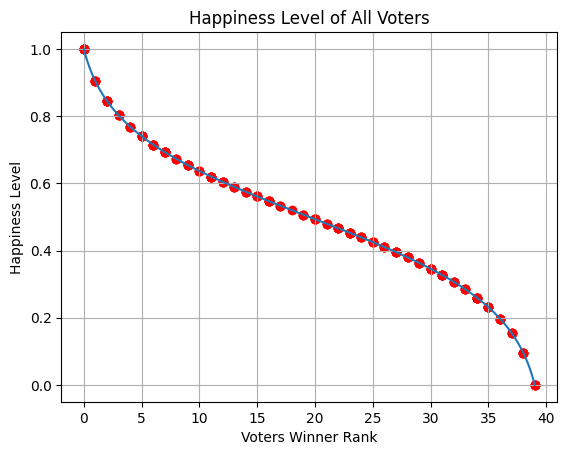

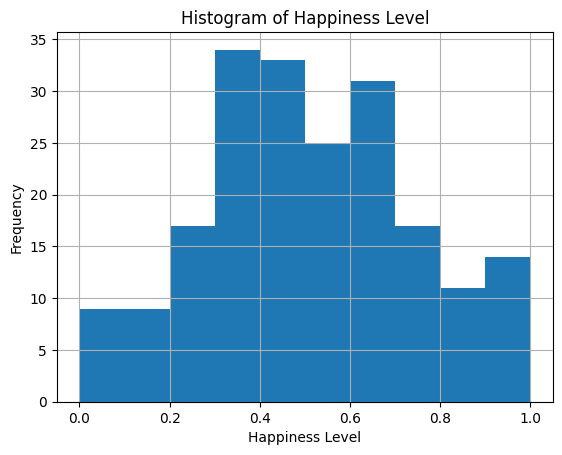

In [4]:
random_voting = utils.random_voting(200, 40)

result_random = plurality_outcome(random_voting)
happiness_level = HappinessLevel(random_voting, result_random.winner)
happiness_level.plot()
happiness_level.histogram()

## Strategic Voting

In [5]:
voting.to_pandas()

,voter_0,voter_1,voter_2,voter_3,voter_4,voter_5
preference_0,C,B,C,C,B,A
preference_1,A,D,D,D,A,D
preference_2,D,C,A,B,D,B
preference_3,B,A,B,A,C,C


In [6]:
result = plurality_outcome(voting)
result

Winner: C
{'A': 1, 'B': 2, 'C': 3, 'D': 0}

Note that **voter 5** is the only voter that can engage in strategic voting. Voter 5 prefers $B$ over the winner $C$. Hence, they can increase their $\text{Happiness Level}$ by placing $B$ as their first preference, resulting in a tie between $C$ and $B$ in the voting outcome (for plurality, voting for two, Borda). Since ties are resolved in alphabetical order, $B$ wins over $C$.

The table below displays the two voting strategies available to voter 5.

In [7]:
happiness_level = HappinessLevel(voting, result.winner)
strategic_voting = StrategicVoting(voting).run(happiness_level, plurality_outcome)

strategic_voting.all

,voter,strategic_voting,new_result,strategic_H,previous_H,strategic_overall_H,previous_overall_H
0,5,"[B, A, D, C]",B,0.410487,0.0,2.820973,3.410487
1,5,"[B, D, A, C]",B,0.410487,0.0,2.820973,3.410487


The table displays the best strategic voting for each voter

In [8]:
strategic_voting.best

,voter,strategic_voting,new_result,strategic_H,previous_H,strategic_overall_H,previous_overall_H
0,5,"[B, A, D, C]",B,0.410487,0.0,2.820973,3.410487


Strategic Voting Risk

In [9]:
strategic_voting.risk

0.13682886358890622

In [304]:
# Import necessary libraries
import warnings

warnings.filterwarnings("ignore")

from typing import List, Tuple
from src import utils
from src.outcomes import plurality_outcome, for_two_outcome, veto_outcome, borda_outcome
from src.happiness_level import HappinessLevel
from src.strategic_voting_risk import StrategicVoting
import os
import numpy as np
from itertools import combinations, permutations
from src.utils import VotingArray
import pandas as pd




<module 'src.coalition_evaluator' from '/Users/andycaen/Desktop/mas-group/src/coalition_evaluator.py'>

In [301]:
path_voting = "input/voting_result.json"
if "env" in os.environ:
    if os.environ["env"] == "docker":
        path_voting = "/input/voting_result.json"

In [302]:
voting = utils.read_voting(path_voting, table_name="voting6")
voting_table = voting.to_pandas()
voting_table

,voter_0,voter_1,voter_2,voter_3,voter_4,voter_5
preference_0,C,C,C,A,D,B
preference_1,A,D,D,B,B,A
preference_2,D,B,A,D,A,D
preference_3,B,A,B,C,C,C


In [325]:
from importlib import reload
import src.coalition_evaluator as coalition_evaluator
reload(coalition_evaluator)
successful_coalitions = coalition_evaluator.evaluate_coalition_strategic_voting_for_two(voting)

# Display the results
print("\nSummary of Successful Coalitions and their Strategic Votes:")
for (coalition, strategic_votes), new_winner, happiness_changes in successful_coalitions:
    formatted_strategic_votes = ', '.join([f'Voter_{v} = {votes}' for v, votes in strategic_votes])
    print(f"Coalition: {coalition}, Strategic Votes: {formatted_strategic_votes}, New Winner: {new_winner}, Happiness Changes: {happiness_changes}")


New voting configuration:
 [['C' 'C' 'C' 'A' 'D' 'B']
 ['A' 'B' 'D' 'B' 'B' 'A']
 ['D' 'D' 'A' 'D' 'A' 'D']
 ['B' 'A' 'B' 'C' 'C' 'C']]
Successful Coalition: (1,), Strategic Votes: {'Voter_1': ('C', 'B')}, New Winner: B
Changes in Happiness Levels for Coalition Members:
Voter 1: Happiness Change = 0.410


New voting configuration:
 [['C' 'D' 'C' 'A' 'D' 'B']
 ['A' 'B' 'D' 'B' 'B' 'A']
 ['D' 'C' 'A' 'D' 'A' 'D']
 ['B' 'A' 'B' 'C' 'C' 'C']]
Successful Coalition: (1,), Strategic Votes: {'Voter_1': ('D', 'B')}, New Winner: B
Changes in Happiness Levels for Coalition Members:
Voter 1: Happiness Change = 0.410


New voting configuration:
 [['C' 'C' 'C' 'A' 'C' 'B']
 ['A' 'B' 'D' 'B' 'B' 'A']
 ['D' 'D' 'A' 'D' 'D' 'D']
 ['B' 'A' 'B' 'C' 'A' 'C']]
Successful Coalition: (1, 4), Strategic Votes: {'Voter_1': ('C', 'B'), 'Voter_4': ('C', 'B')}, New Winner: B
Changes in Happiness Levels for Coalition Members:
Voter 1: Happiness Change = 0.410
Voter 4: Happiness Change = 0.179


New voting configura